# Example usage for the DONHa classifier

<font size=2>_by Babis Daoutis, last update 2024/09_</font>
- - -
**Description**

This notebook provides an application example for the `DONHa` (**D**4000, [**O**III], [**N**II], and H**α**) classifier, which allows to categorize your sources in terms of their activity.

With very simple functions calls, it guides you from importing the galaxy dataset to the final classification, using the provided data `test_sample_galaxies.csv`.<br>
It is organized into three sections:

- **Section 0**: Importing the necessary Python packages and defines the functions required for classification.
- **Section 1**: Applying the `DOHNa` classifier on the imported galaxy data.
- **Section 2 (extra)**: Calculating the percentual composition of the sample for each activity class as determined by the DOHNa classifier and plotting a histogram for visualization (this section is optional).

**Application to your own data**

Only the first, second, and last cells of Section 2 require user modification to specify the local path to the relevant files.

The galaxy dataset must may be supplied in `.csv` or `.fits` format.<br>
Your data columns must contain Hα, [O III] 5007, [N II] 6584, and D4000 $-$ in this specific order.

**Acknowledgements**

Please cite [Daoutis, C. et al. 2024 (under review)](link)
- - -

## Step 0 - Import packages and define utility functions

_You will not need to edit this block_

In [1]:
import os 
from astropy.table import Table
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
import math

In [2]:
def load_file(name, file_format):
    """
    Load a file based on the given format.

    Parameters
    ----------
    name : str
        The base name of the file (without extension).
    file_format : str
        The format of the file, either 'csv' or 'fits'.

    Return
    ------
    df : pandas.DataFrame
        The loaded data.    
    """
    if file_format=='csv':
        df = pd.read_csv(name+'.csv')
    elif file_format=='fits':
        dat = Table.read(name+'.fits', format='fits')
        df = dat.to_pandas()
    return df

In [3]:
def do_classification(clf, dfc):
    """
    Apply DOHa to classify/decompose the activity of galaxies based on their features.
    (in practice, any pre-trained Random Forest model can be passed as classifier).

    This function takes a pre-trained Random Forest classifier and a DataFrame
    of features, and predicts the probabilities for each object belonging to
    7 different classes:
        0: 'Pure SB'
        1: 'Pure AGN'
        2: 'Pure Pas'
        3: 'SB-AGN'
        4: 'AGN-SB'
        5: 'SB-pas'
        6: 'Pas-SB'
        7: 'Pas-AGN'
        8: 'AGN-pas'
        -1: 'Unclassified'
    (please consult the paper for more details on the class definitions). 
    
    It then classifies the objects into specific classes or hybrid classes
    based on their predicted probabilities and defined thresholds.

    Parameters
    ----------
    clf : RandomForestClassifier
        A pre-trained Random Forest classifier used for predicting the
        class probabilities.
    dfc : pandas.DataFrame
        A DataFrame containing the feature data of the objects to be
        classified.

    Return
    ------
    dfp : pandas.DataFrame
        A DataFrame with the original features, predicted probabilities for
        each class, and the final classification (column: 'classification'
        indicating the category of each object.
    """
    dfc.reset_index(inplace=True, drop=True)
    df_pr = pd.DataFrame(clf.predict_proba(dfc), columns=['proba_RF_SFG', 'proba_RF_AGN', 'proba_RF_PAS'])
    dfp = pd.concat([dfc, df_pr], axis=1)
    dfp['RF_label'] = clf.predict(dfc)
    dfp['mx_prb_mns_sc'] = None
    dfp['mx_prb'] = None
    dfp['scmx_prb_mns_lst'] = None
    dfp['scmx_prb'] = None
    dfp['classification'] = None
    
    for i in range(0, len(df_pr)):
        l = df_pr.iloc[i].tolist()
        nw_ls = [x for x in l if not math.isnan(x)]
        l = nw_ls
        l.sort()
        dfp.loc[i, 'mx_prb_mns_sc'] = l[-1] - l[-2]
        dfp.loc[i, 'mx_prb'] = max(l)
        dfp.loc[i, 'scmx_prb_mns_lst'] = l[1] - l[0]
        dfp.loc[i, 'scmx_prb'] = l[1]
    
    dft = df_pr.T
    for i in range(0, len(df_pr)):
        fst_cls = dft[i].index[np.where((dft[i] == np.max(dft[i])))].tolist()[0]
        snd_cls = dft[i].index[np.where((dft[i] == np.median(dft[i])))].tolist()[0]
        RF_LBL = dfp['RF_label'].iloc[i]
        
        thres = 0.90 
        c = 0.8 # (this can be modified, see the paper)
        
        if dfp['mx_prb_mns_sc'].iloc[i] < -2 * dfp['scmx_prb_mns_lst'].iloc[i] + c:  # delta_p = -2 * dp' + c
            dfp.loc[i, 'classification'] = -1
        elif dfp['mx_prb'].iloc[i] >= thres and fst_cls == 'proba_RF_SFG':
            dfp.loc[i, 'classification'] = 0
        elif dfp['mx_prb'].iloc[i] >= thres and fst_cls == 'proba_RF_AGN': 
            dfp.loc[i, 'classification'] = 1
        elif dfp['mx_prb'].iloc[i] >= thres and fst_cls == 'proba_RF_PAS':
            dfp.loc[i, 'classification'] = 2
        elif dfp['mx_prb'].iloc[i] < thres and fst_cls == 'proba_RF_SFG' and snd_cls == 'proba_RF_AGN' and RF_LBL == 0:
            dfp.loc[i, 'classification'] = 3
        elif dfp['mx_prb'].iloc[i] < thres and fst_cls == 'proba_RF_AGN' and snd_cls == 'proba_RF_SFG' and RF_LBL == 1:
            dfp.loc[i, 'classification'] = 4
        elif dfp['mx_prb'].iloc[i] < thres and fst_cls == 'proba_RF_SFG' and snd_cls == 'proba_RF_PAS' and RF_LBL == 0:
            dfp.loc[i, 'classification'] = 5
        elif dfp['mx_prb'].iloc[i] < thres and fst_cls == 'proba_RF_PAS' and snd_cls == 'proba_RF_SFG' and RF_LBL == 2:
            dfp.loc[i, 'classification'] = 6
        elif dfp['mx_prb'].iloc[i] < thres and fst_cls == 'proba_RF_PAS' and snd_cls == 'proba_RF_AGN' and RF_LBL == 2:
            dfp.loc[i, 'classification'] = 7
        elif dfp['mx_prb'].iloc[i] < thres and fst_cls == 'proba_RF_AGN' and snd_cls == 'proba_RF_PAS' and RF_LBL == 1:
            dfp.loc[i, 'classification'] = 8
        else:
            break

    dfp.drop('RF_label', axis=1, inplace=True)
    return dfp

---

## Step 1 - Apply classification

_You may edit this block to adapt it to your data, where specified_

In [5]:
# load the file that contains the galaxies to be classified
data = load_file('test_sample_galaxies','csv')
#Your custom data: data = load_file('path/to/your/data','csv')

# display a few rows of the dataset 
display(data.head(3))
# NOTE: Observe how the dataset is complex and contains multiple columns - we will
#       specify the necessary ones in the following block.

,index,SPECOBJID_1,MJD_1,PLATEID_1,FIBERID_1,SIGMA_BALMER,SIGMA_BALMER_ERR,SIGMA_FORBIDDEN,SIGMA_FORBIDDEN_ERR,V_OFF_BALMER,...,fiberMag_g_CORR,fiberMag_r_CORR,NUV-r,g-r_ext_corr,NUV_k_corr,r_ext_k_corr,NUV-r_ek_CORR,M_r,fM_r,new_class
0,60525,b'1527927588347996160',53034,1357,296,113.17921,6.007657,126.92221,7.095107,5.471788,...,[19.19482049],[18.32036278],[3.91033467],[0.79788771],21.148453,17.228375,3.920078,-20.110729,-18.986604,2
1,844238,b'2739419815675455488',53820,2433,383,141.16058,7.004882,160.92080,8.597886,47.390976,...,[19.17830525],[18.11356324],[inf],[0.70830201],NaN,15.916210,NaN,-21.677007,-19.381517,2
2,683633,b'2795714811554457600',53852,2483,383,211.85281,10.123327,209.07669,7.154931,-40.427856,...,[18.1482089],[17.12601071],[inf],[0.62570819],NaN,14.575699,NaN,-21.263269,-18.646248,2


In [6]:
 # load the model - replace this with the path where you have stored the "DONHa_classifier.sav" file
filename = 'DONHa_classifier.sav' 
model = joblib.load(filename)

# name of columns required by DONHa
column_names = ['H_ALPHA_EQW','OIII_5007_EQW','NII_6584_EQW','D4000_N']

<div class="alert alert-warning alertwarning" style="margin-top: 20px">
        
NOTE: 
Your column names do not have to necessarily match these names.

However, ensure your column names do correspond to the equivalent widths of Hα, [O III] 5007, [N II] 6584, and D4000 $-$ in this specific order.
   
</div>

In [7]:
# name replacement to match the column names used during DOHa training
data = data.rename(columns={column_names[0] : model.feature_names_in_[0],
                            column_names[1] : model.feature_names_in_[1],
                            column_names[2] : model.feature_names_in_[2],
                            column_names[3] : model.feature_names_in_[3]})

In [8]:
# perform classification
df_class = do_classification(model, data[column_names])

In [9]:
# save the results on a csv file (optional)
df_class.to_csv('DONHa_classification_result.csv', index=False) 
#Your custom path: df_class.to_csv('path/to/DONHa_classification_result.csv', index=False) 

-----

## Step 2 (optional) - Visualize the classification result

In [10]:
# count instances of each class encountered in the classified data
demographics = {
    'Pure SB':  len(df_class[df_class['classification'] == 0]),
    'SB-AGN':   len(df_class[df_class['classification'] == 3]),
    'SB-pas':   len(df_class[df_class['classification'] == 5]),
    'Pure AGN': len(df_class[df_class['classification'] == 1]),
    'AGN-SB':   len(df_class[df_class['classification'] == 4]),
    'AGN-pas':  len(df_class[df_class['classification'] == 8]),
    'Pure pas': len(df_class[df_class['classification'] == 2]),
    'Pas-SB':   len(df_class[df_class['classification'] == 6]),
    'Pas-AGN':  len(df_class[df_class['classification'] == 7]),
    'Inconclusive': len(df_class[df_class['classification'] == -1])
}

total = sum(demographics.values())
print('Class demographics:')
for category, count in demographics.items():
    percentage = (count / total) * 100
    print("  %-.12s %.1f%%" % (category.ljust(12, '.'), percentage))

Class demographics:
  Pure SB..... 17.0%
  SB-AGN...... 6.0%
  SB-pas...... 19.0%
  Pure AGN.... 1.0%
  AGN-SB...... 5.0%
  AGN-pas..... 6.0%
  Pure pas.... 22.0%
  Pas-SB...... 16.0%
  Pas-AGN..... 1.0%
  Inconclusive 7.0%


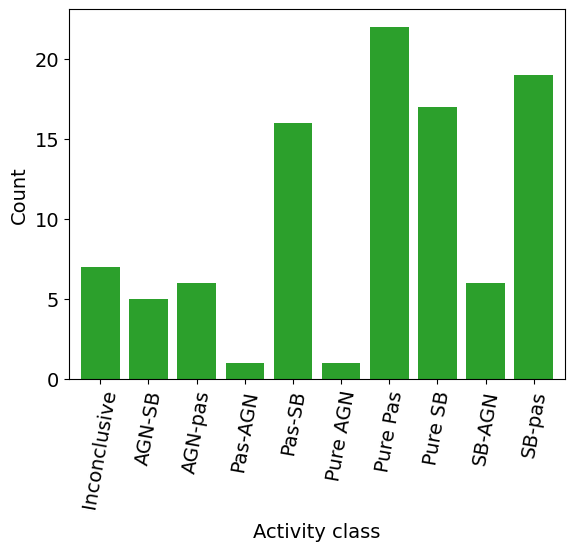

In [11]:
df_class_str = df_class.copy() # same as `df_class`, but the class is a string instead of a digit
df_class_str.loc[:, 'classification'] = df_class_str['classification'].replace({0: 'Pure SB', 1: 'Pure AGN', 2: 'Pure Pas', 3: 'SB-AGN', 4: 'AGN-SB', 5: 'SB-pas', 6: 'Pas-SB', 7: 'Pas-AGN', 8: 'AGN-pas', -1: ' Inconclusive'})

counts = df_class_str['classification'].value_counts().sort_index()
counts.plot(kind='bar', color='C2', align='center', width=0.8)
plt.xlabel('Activity class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=80, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# EOF